In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Read in the ratings file (fromUserId, toUserId, rating).  These ratings are 0-9.
ratings_raw = sc.textFile("s3n://insight-spark-after-dark/gender.csv.gz")

In [5]:
ratings_raw.count()

220970

In [6]:
# Task 1: Parse each record so that we have a tuple of (gender(string), id(int)) and show 
# the first 5 results
split_rdd = ratings_raw.map(lambda r: r.split(','))
parsed_rdd = split_rdd.map(lambda r: (r[1], int(r[0])))
parsed_rdd.take(5)

[(u'F', 1), (u'F', 2), (u'U', 3), (u'F', 4), (u'F', 5)]

['U', 'M', 'F']
[83164, 76441, 61365]


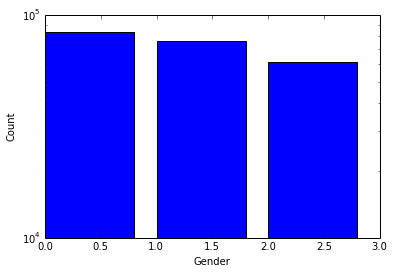

In [10]:
# Task 2: Calculate the distribution of Males, Females, and Unknowns and show the results
tagged_rdd = parsed_rdd.map(lambda r: (r[0], 1))
distribution = tagged_rdd.reduceByKey(lambda x,y: x+y)
distr = distribution.collect()
gender = [str(val[0]) for val in distr]
idx = range(3)
count = [val[1] for val in distr]
bar(idx, count, log=1)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks

print gender
print count

In [24]:
# Task 3: Calculate the sum of all the IDs for each gender
id_sum_rdd = parsed_rdd.reduceByKey(lambda x,y: x+y)
id_sum_rdd.collect()

[(u'U', 13105654827), (u'M', 6982853010), (u'F', 4325473098)]

In [26]:
# Task 4: Calculate the average of all the IDs for each gender
sum_cnt_rdd = parsed_rdd.aggregateByKey((0,0),
                                       lambda x,y: (x[0]+y, x[1]+1),
                                       lambda x,y: (x[0]+y[0], x[0]+y[0]))
avg_rdd = sum_cnt_rdd.mapValues(lambda r: r[0]/r[1])
avg_rdd.collect()

[(u'U', 157588), (u'M', 91349), (u'F', 70487)]

In [32]:
# Task 5: Only return records from parsed_rdd which have ids that are a multiple of 5 and 
# show the first 5 results
filtered_rdd = parsed_rdd.filter(lambda r: r[1]%5==0)
filtered_rdd.take(5)

[(u'F', 5), (u'M', 10), (u'U', 15), (u'M', 20), (u'F', 25)]